# 2. 1D Sequential Data and DNN Models with History

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (06/02/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Numpy (tested on v1.23.5)
- Torch (tested on v1.12.1)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Dataset generation with history

Our dataset object will be adjusted, to include history, that is additional data points beyond the current observation, as inputs.

We define the history length as the number of points to include in the history.

We will demonstrate with 2 datapoints (or a history length of 2), meaning at each time $ t $, the model will receive $ x_t $ and $ x_{t-1} $ as inputs to predict what the next value $ x_{t+1} $ might be. 

In [3]:
# Our custom Dataset object
class CustomSeriesDataset(Dataset):
    def __init__(self, datapoints, history_len = 2):
        self.history_len = history_len
        self.inputs_number = self.history_len
        self.outputs_number = 1
        self.datapoints = datapoints
        self.inputs = [np.round(datapoints[i:(i+self.inputs_number)], 3) \
                       for i in range(len(datapoints) - self.inputs_number - 1)]
        self.outputs = [datapoints[(i+self.inputs_number):(i + self.inputs_number + self.outputs_number)] \
                        for i in range(len(datapoints) - self.inputs_number - 1)]
    def __len__(self):
        return len(self.outputs)
    def __getitem__(self, index):
        inputs = torch.tensor(self.inputs[index]).float()
        outputs = torch.tensor(self.outputs[index]).float().reshape(-1)
        return inputs, outputs

In [4]:
# Create dataset and dataloader
np.random.seed(27)
datapoints = [np.sin(2*np.pi*i/50) for i in range(1000)]
dataset = CustomSeriesDataset(datapoints, history_len = 2)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = False)

Inputs indeed consist of two values. Outputs remain unchanged.

In [5]:
# Fetch a datapoint
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0][20]
outputs_test = data[1][20]
print(inputs_test)
print(outputs_test)

tensor([0.5880, 0.4820])
tensor([0.3681])


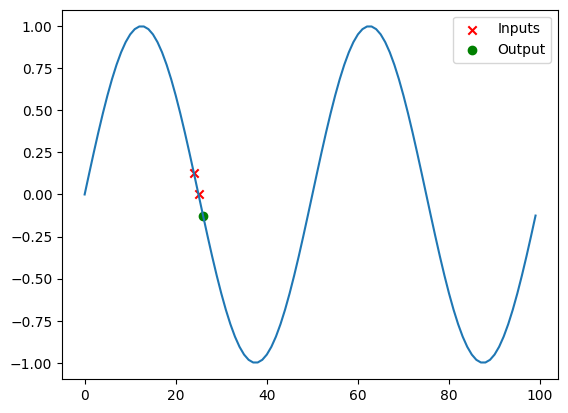

In [6]:
# Show the first 100 points
plt.plot(datapoints[:100])
plt.scatter(24, np.sin(2*np.pi/50*24), c = 'r', marker = 'x', label = 'Inputs')
plt.scatter(25, 0, c = 'r', marker = 'x')
plt.scatter(26, np.sin(2*np.pi/50*26), c = 'g', label = 'Output')
plt.legend(loc = "best")
plt.show()

### Building an autoregressive model with history

We will adjust our DNN to simply account for the length of the history, adjusting the number of parameters in the first layer to match the history length.

In [7]:
class DNN_model_with_history(torch.nn.Module):
    def __init__(self, history_len):
        super(DNN_model_with_history, self).__init__()
        
        # Lag
        self.history_len = history_len
        # Define layers
        self.layers = torch.nn.Sequential(torch.nn.Linear(self.history_len, 32),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(32, 8),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(8, 1))
    
    def forward(self, inputs):
        out = self.layers(inputs)
        return out

In [8]:
model = DNN_model_with_history(history_len = 2).to(device)
print(model.layers)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)


Just like before, we test our DNN forward method to confirm the consistency in terms of sizes.

In [9]:
# Fetch a datapoint and try out model prediction
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0]
outputs_test = data[1]
print("Inputs tensor shape: ", inputs_test.shape)
print("Targets tensor shape: ", outputs_test.shape)
pred = model(inputs_test.to(device))
print("Predicted tensor shape: ", pred.shape)

Inputs tensor shape:  torch.Size([64, 2])
Targets tensor shape:  torch.Size([64, 1])
Predicted tensor shape:  torch.Size([64, 1])


### Trainer function

Our trainer function does not need to be adjusted, we can reuse the same one as before.

In [10]:
def train(model, dataloader, num_epochs, learning_rate, device):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs.to(device), targets.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [11]:
# Train the model
model = DNN_model_with_history(history_len = 2).to(device)
train(model, dataloader, num_epochs = 20, learning_rate = 0.01, device = device)

Epoch 1/20, Loss: 0.0723
Epoch 2/20, Loss: 0.0243
Epoch 3/20, Loss: 0.0173
Epoch 4/20, Loss: 0.0129
Epoch 5/20, Loss: 0.0091
Epoch 6/20, Loss: 0.0067
Epoch 7/20, Loss: 0.0046
Epoch 8/20, Loss: 0.0025
Epoch 9/20, Loss: 0.0012
Epoch 10/20, Loss: 0.0004
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0001
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


### Test model predictions

Loss has decreased and reached much lower values, but we need to confirm the predictions capabilities of the model by testing it.

If we try the two problematic values we had identified earlier, we can now observe that the model is able to correctly predcict, thanks to the additional value $ x_{t-1} $ being passed as input.

In [12]:
for batch in dataloader:
    inputs, outputs = batch
    print("Input for sample #24: ", inputs[24])
    print("Output for sample #24: ", outputs[24])
    print("Model prediction for sample #24:", model(inputs[24].to(device)))
    print("Input for sample  #49: ", inputs[49])
    print("Output for sample  #49: ", outputs[49])
    print("Model prediction for sample #49:", model(inputs[49].to(device)))
    break

Input for sample #24:  tensor([0.1250, 0.0000])
Output for sample #24:  tensor([-0.1253])
Model prediction for sample #24: tensor([-0.1281], device='cuda:0', grad_fn=<AddBackward0>)
Input for sample  #49:  tensor([-0.1250, -0.0000])
Output for sample  #49:  tensor([0.1253])
Model prediction for sample #49: tensor([0.1248], device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
def test_display(seed, dataloader, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(dataloader))
    inputs_test = data[0]
    outputs_test = data[1]

    # Display
    pred = model(inputs_test.to(device)).detach().cpu()
    fig = plt.plot(range(2), inputs_test[0], "b", label = "Inputs")
    plt.scatter(range(2, 3), outputs_test[0], c = "r", label = "Targets")
    plt.scatter(range(2, 3), pred[0], c = "g", marker = "x", label = "Predictions")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

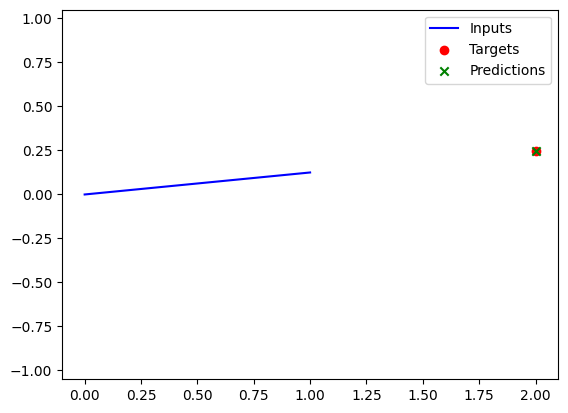

In [14]:
# Try it
test_display(seed = 5, dataloader = dataloader, model = model, device = device)

### Higher history length generation

We could of course try to play with more elements in the history, for instance increasing the history size to 10.

This means we now pass an input at time $ t $, which consists of all 10 values $ (x_{t-9}, x_{t-1}, x_t) $.

Hoping that this additional information will help the model train better!

In [15]:
# Create dataset and dataloader
np.random.seed(27)
datapoints = [np.sin(2*np.pi*i/50) for i in range(1000)]
dataset = CustomSeriesDataset(datapoints, history_len = 10)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
# Fetch a datapoint
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0][0]
outputs_test = data[1][0]
print(inputs_test)
print(outputs_test)

tensor([ 0.4820,  0.3680,  0.2490,  0.1250,  0.0000, -0.1250, -0.2490, -0.3680,
        -0.4820, -0.5880])
tensor([-0.6845])


In [16]:
# Train the model
model2 = DNN_model_with_history(history_len = 10).to(device)
train(model2, dataloader, num_epochs = 20, learning_rate = 0.01, device = device)

Epoch 1/20, Loss: 0.0051
Epoch 2/20, Loss: 0.0004
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


Loss has decreased in an even faster way, and predictions are better than ever!

This confiorms that having a longer history length is beneficial (but might lead to overfitting, so careful!)

In [17]:
def test_display2(seed, dataloader, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(dataloader))
    inputs_test = data[0]
    outputs_test = data[1]

    # Display
    pred = model(inputs_test.to(device)).detach().cpu()
    fig = plt.plot(range(10), inputs_test[0], "b", label = "Inputs")
    plt.scatter(range(10, 11), outputs_test[0], c = "r", label = "Targets")
    plt.scatter(range(10, 11), pred[0], c = "g", marker = "x", label = "Predictions")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

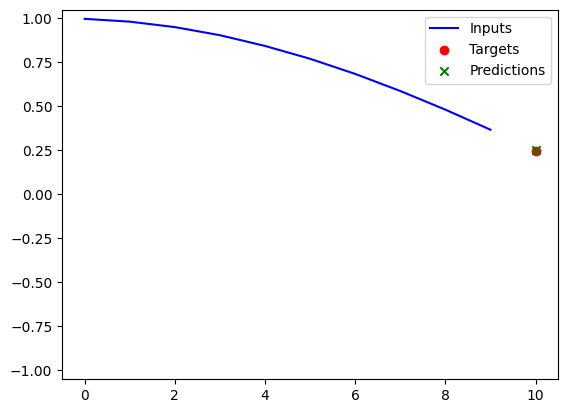

In [18]:
# Try it
test_display2(seed = 5, dataloader = dataloader, model = model2, device = device)

### What's next?

We will continue by implementing a memory into our Deep Neural Networks, and eventually implement our first Recurrent Neural Network!